In [1]:
import pandas as pd
import numpy as np
import sqlalchemy as sa

import dbcp

/app/.local/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
eng = dbcp.helpers.get_sql_engine()

In [3]:
q = """
SELECT
    "raw_state_name",
    "raw_county_name",
    "raw_town_name",
    "energy_type",
    "ordinance_type",
    "units",
    "value",
    "update_status",
    "geocoded_containing_county",
    "geocoded_locality_name",
    "geocoded_locality_type",
    "state_id_fips",
    "county_id_fips",
    "raw_comment",
    "raw_units",
    "raw_updated_comment",
    "raw_updated_unit",
    "raw_updated_value",
    "raw_value"
FROM "data_warehouse"."nrel_local_ordinances"
"""
nrel = pd.read_sql(q, eng)

In [4]:
nrel.shape

(2671, 19)

In [33]:
# John Droz (anti-renewable guy) Criteria
droz_setback = 5280 * 12 * 2.54 / 100 -10 # 1 mile to meters, -10 for rounding errors. From property lines
droz_sound = 35 # dbA from property lines

In [6]:
nrel[['energy_type', 'units']].value_counts(sort=False).sort_index()

energy_type  units                              
solar        acres                                   71
             dba                                     36
             maximum structure height multiplier     10
             megawatts                                1
             meters                                 707
             percentage                               9
wind         acres                                   23
             dba                                    218
             hrs/year                                13
             hub height multiplier                    8
             kw                                       2
             max tip height multiplier              903
             meters                                 548
             minimum lot size                         1
             rotor diameter multiplier               57
             rotor radius multiplier                  1
             turbines                                 4

In [7]:
from scipy.optimize import root_scalar
from functools import partial

In [8]:
def sound_to_distance(received_db_target, source_db=106, attenuation_dbm=0.005):
    # Root finder on this simple sound model: https://www.wkcgroup.com/tools-room/wind-turbine-noise-calculator/
    def received_db_func(r):
        return source_db - 10 * np.log10(2*np.pi*r*r) - attenuation_dbm * r
    def objective_func(r):  # set equal to 0
        return received_db_func(r) - received_db_target
#    def objective_func_derivative(r):
#        return -20 / (r * np.log(10))- attenuation_dbm
#    def objective_func_2nd_derivative(r):
#        return 20 / np.log(10) * np.power(r, -2)
    distance = root_scalar(objective_func,# fprime=objective_func_derivative, fprime2=objective_func_2nd_derivative,
                           bracket=(0.1, 1e5), x0=570, xtol=0.01, method='brentq', maxiter=100)
    if not distance.converged:
        raise ValueError(f"sound model failed to converge with target {received_db_target} dB and source power {source_db} dB")
    return distance.root

In [25]:
sound_to_distance(40)

572.5093256244426

In [10]:
def standardize_units_to_distances(nrel_df: pd.DataFrame) -> pd.Series:
    # NOTE: solar sound limits really apply to inverters, not to panels.
    # They are not directly comparable and should probably be treated separately.
    
    # Constants used to convert multipliers to constant distances.
    # Based on reference turbine of 127m rotor diameter, 89m hub height, 3 MW
    _rotor_diameter = 127.0
    reference_map = {
        "maximum structure height multiplier": 15 * 12 * 2.54 /100,  # 15 feet to meters. For solar.
        "hub height multiplier": 89.0,
        "max tip height multiplier": 152.0, # 500 foot FAA soft cap
        "rotor diameter multiplier": _rotor_diameter,
        "rotor radius multiplier": _rotor_diameter / 2
    }
    unit_map = {key: 'meters' for key in reference_map.keys()}
    unit_map['dba'] = 'meters'
    
    constants = nrel_df['units'].map(reference_map).fillna(1.0)
    standardized_values = nrel_df['value'].mul(constants).rename('standardized_value')
    standardized_units = nrel_df['units'].replace(unit_map).rename('standardized_units')
    
    # solar reference: https://rsginc.com/wp-content/uploads/2021/04/Kaliski-et-al-2020-An-overview-of-sound-from-commercial-photovolteic-facilities.pdf
    # 2 MW inverter w/ cooling fan ~100dB
    reference_sound_power_db = {'solar': 100, 'wind': 106}
    for energy_type, source_db in reference_sound_power_db.items():
        sound_estimate = partial(sound_to_distance, source_db=source_db)
        energy_filter = nrel_df['energy_type'].eq(energy_type) & nrel_df['units'].eq('dba')
        noise = nrel_df.loc[energy_filter, 'value'].apply(sound_estimate)
        standardized_values.loc[energy_filter] = noise
    return pd.concat([standardized_units, standardized_values], axis=1, copy=False)
    

In [11]:
standardized = standardize_units_to_distances(nrel)

In [12]:
standardized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2671 entries, 0 to 2670
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   standardized_units  2612 non-null   object 
 1   standardized_value  2612 non-null   float64
dtypes: float64(1), object(1)
memory usage: 41.9+ KB


In [13]:
standardized

,standardized_units,standardized_value
0,None,NaN
1,meters,572.509326
2,meters,782.000000
3,meters,228.000000
4,meters,572.509326
...,...,...
2666,meters,60.959999
2667,meters,30.480000
2668,meters,4.572000
2669,percentage,10.000000


In [14]:
standardized.describe()

,standardized_value
count,2612.000000
mean,233.240526
std,460.652652
min,0.000000
25%,43.651279
50%,167.200004
75%,228.000000
max,8500.000000


In [16]:
nrel = pd.concat([nrel, standardized], axis=1)

In [26]:
nrel.loc[standardized['standardized_value'].nlargest(5).index | standardized['standardized_value'].nsmallest(5).index,:]

/tmp/ipykernel_14/376291384.py:1: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  nrel.loc[standardized['standardized_value'].nlargest(5).index | standardized['standardized_value'].nsmallest(5).index,:]


,raw_state_name,raw_county_name,raw_town_name,energy_type,ordinance_type,units,value,update_status,geocoded_containing_county,geocoded_locality_name,geocoded_locality_type,state_id_fips,county_id_fips,raw_comment,raw_units,raw_updated_comment,raw_updated_unit,raw_updated_value,raw_value,standardized_units,standardized_value
416,Indiana,Koscuisko,None,wind,shadow flicker,hrs/year,0.000000,None,Kosciusko County,Kosciusko County,county,18,18085,None,Hrs/Year,None,None,NaN,0,hrs/year,0.000000
436,Indiana,Montgomery,None,wind,shadow flicker,hrs/year,0.000000,None,Montgomery County,Montgomery County,county,18,18107,None,Hrs/Year,None,None,NaN,0,hrs/year,0.000000
446,Indiana,Posey,None,wind,shadow flicker,hrs/year,0.000000,None,Posey County,Posey County,county,18,18129,None,Hrs/Year,None,None,NaN,0,hrs/year,0.000000
460,Indiana,Rush,None,wind,shadow flicker,hrs/year,0.000000,None,Rush County,Rush County,county,18,18139,None,Hrs/Year,None,None,NaN,0,hrs/year,0.000000
487,Indiana,Wabash,None,wind,shadow flicker,hrs/year,0.000000,None,Wabash County,Wabash County,county,18,18169,None,Hrs/Year,None,None,NaN,0,hrs/year,0.000000
611,Iowa,Fremont,None,wind,water,meters,4828.032227,None,Fremont County,Fremont County,county,19,19071,"15,840' setback from the Missouri River",Meters,None,None,NaN,4828.032,meters,4828.032227
1449,North Dakota,Pierce,None,wind,maximum capacity,kw,5000.000000,None,Pierce County,Pierce County,county,38,38069,None,KW,None,None,NaN,5000 or less,kw,5000.000000
1463,North Dakota,Towner,None,wind,maximum capacity,kw,5000.000000,None,Towner County,Towner County,county,38,38095,None,KW,None,None,NaN,5000 or less,kw,5000.000000
2578,Virginia,Brunswick,None,solar,total installation size,acres,8500.000000,None,Brunswick County,Brunswick County,county,51,51025,None,Acres,None,None,NaN,8500,acres,8500.000000
2595,Virginia,Greensville,None,solar,total installation size,acres,7600.000000,None,Greensville County,Greensville County,county,51,51081,None,Acres,None,None,NaN,7600,acres,7600.000000


In [17]:
nrel[['energy_type', 'ordinance_type', 'standardized_units']].value_counts(sort=False, dropna=False).sort_index()

energy_type  ordinance_type           standardized_units
solar        banned                   NaN                     4
             density                  meters                  4
                                      percentage              1
             height                   meters                190
             highways                 meters                 23
             maximum lot coverage     percentage              8
             maximum lot size         acres                  14
             maximum project size     acres                   1
                                      megawatts               1
             minimum lot size         acres                  50
             property line            meters                233
             railroads                meters                  1
             roads                    meters                118
             sound                    meters                 36
             structures               meters   

In [18]:
nrel[['energy_type', 'ordinance_type', 'standardized_units']].value_counts(dropna=False).nlargest(15)

energy_type  ordinance_type    standardized_units
wind         structures        meters                372
             property line     meters                354
             roads             meters                344
solar        property line     meters                233
wind         sound             meters                220
solar        height            meters                190
wind         transmission      meters                182
solar        structures        meters                137
             roads             meters                118
wind         height            meters                 91
             water             meters                 66
             railroads         meters                 61
             banned            NaN                    55
solar        minimum lot size  acres                  50
             sound             meters                 36
dtype: int64

In [19]:
main_groups = nrel.groupby(['energy_type', 'ordinance_type', 'standardized_units']).filter(lambda x: x.shape[0] > 30)

In [22]:
import matplotlib.pyplot as plt

In [23]:
def grouped_hist(df, groups, target_col, width_per_plot=7, height_per_plot=5):
    grouped = df.groupby(groups)
    n = grouped.ngroups
    nrows = int(np.ceil(n / 2))
    fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(width_per_plot*2, height_per_plot*nrows))
    for i, grp in enumerate(grouped):
        name, grp_df = grp
        ax_row = i // 2
        ax_col = i % 2
        sample_size = len(grp_df)
        ax = axes[ax_row, ax_col]
        
        ax.hist(grp_df[target_col], bins=max(10, int(2*sample_size**0.5)))
        ax.set_title(name)

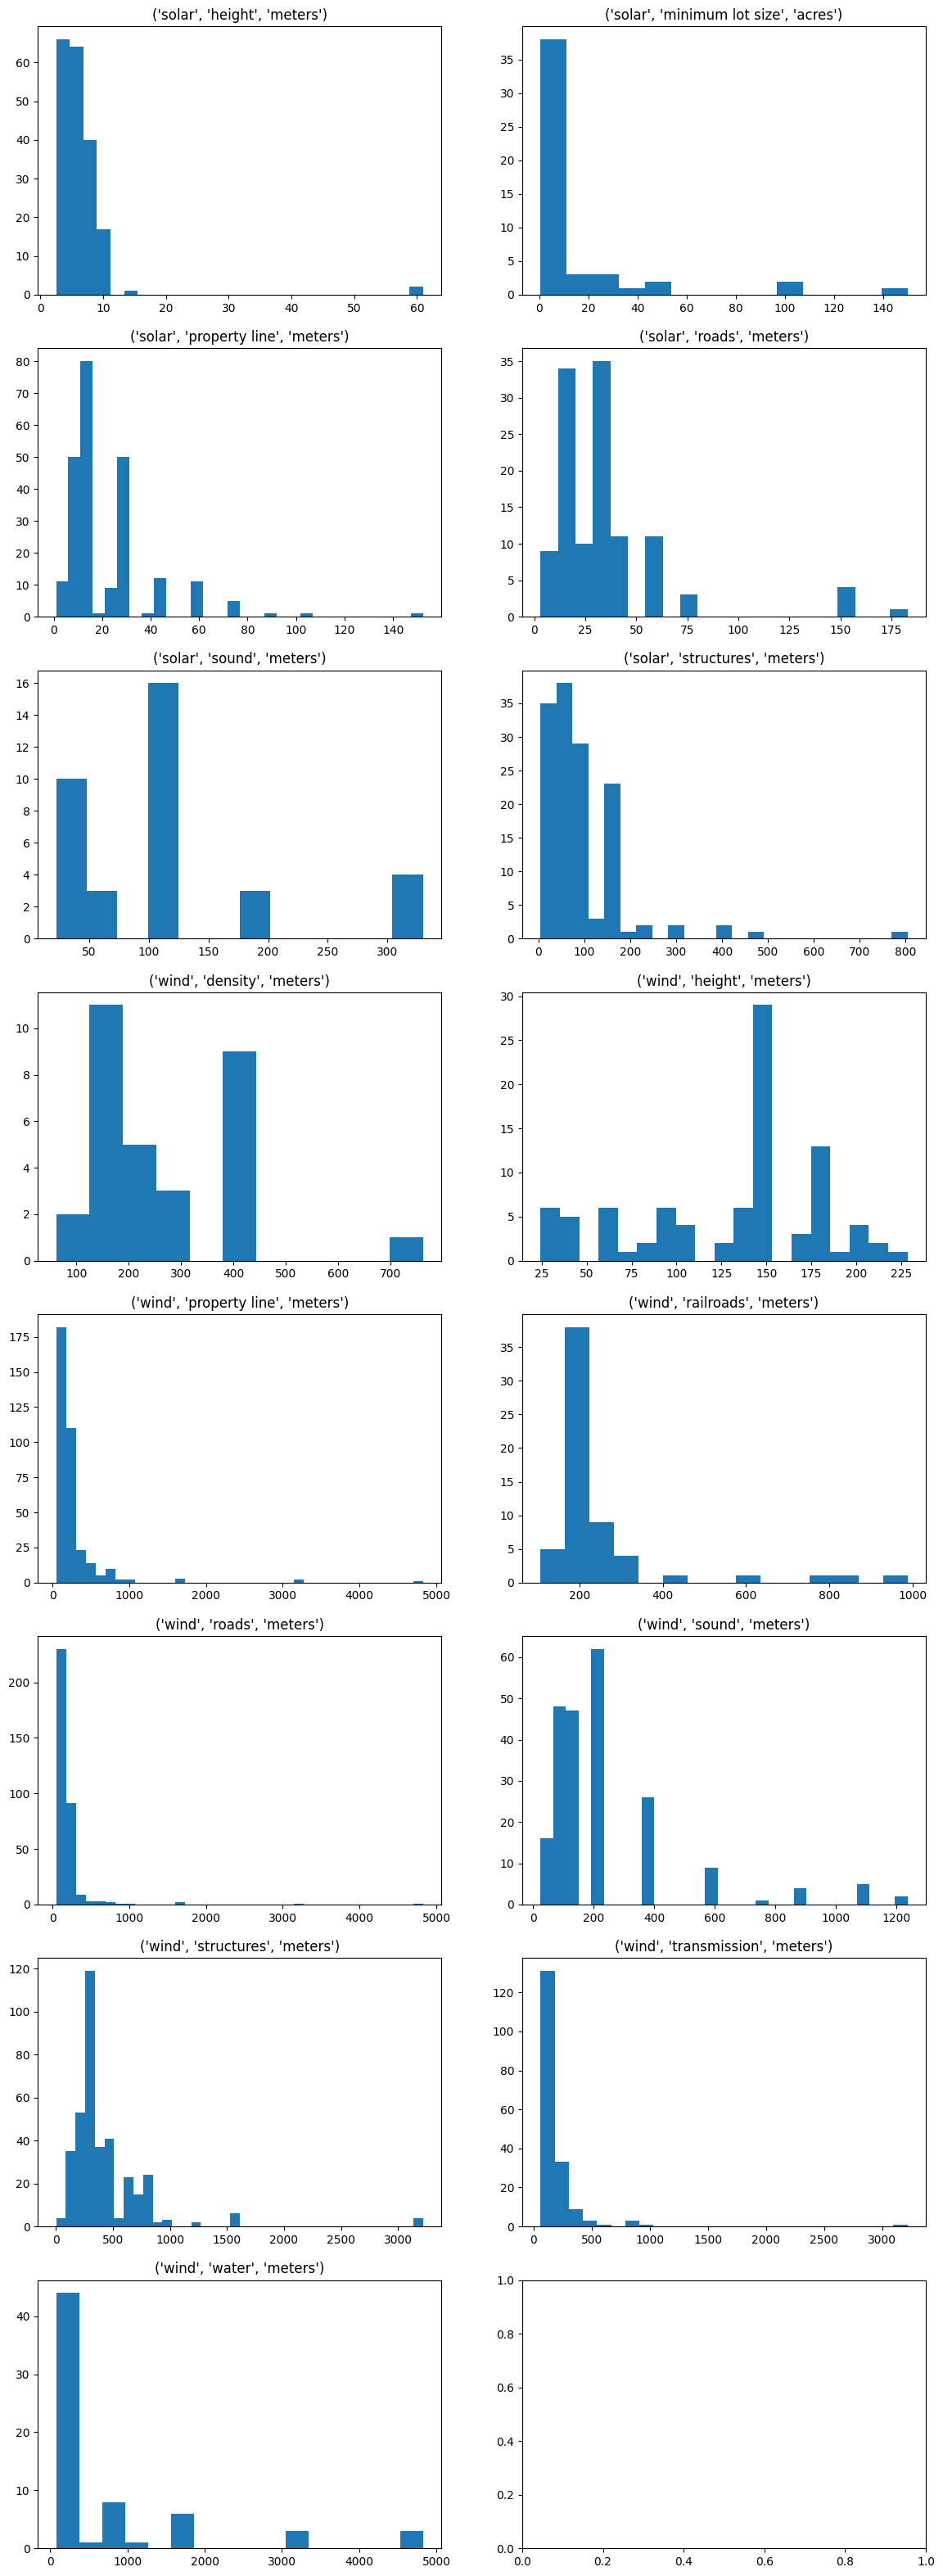

In [24]:
grouped_hist(main_groups, ['energy_type', 'ordinance_type', 'standardized_units'], 'standardized_value')

<AxesSubplot: >

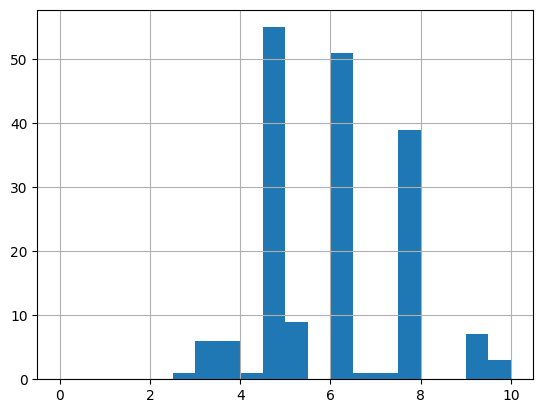

In [29]:
nrel.query('energy_type == "solar" and ordinance_type == "height"')['standardized_value'].hist(bins=20, range=(0,10))

In [30]:
nrel.query('energy_type == "solar" and ordinance_type == "height"')['standardized_value'].nsmallest(5)

2347    2.500
2002    3.000
2139    3.040
2322    3.040
1898    3.048
Name: standardized_value, dtype: float64

In [34]:
ban_droz_setback = nrel['standardized_units'].eq('meters') & nrel['standardized_value'].ge(droz_setback)
ban_droz_sound = nrel['units'].eq('dba') & nrel['value'].le(droz_sound)
ban_droz = nrel.loc[ban_droz_setback | ban_droz_sound, :]
ban_droz_setback.sum(), ban_droz_sound.sum(), len(ban_droz)

(39, 11, 50)

In [35]:
ban_droz['energy_type'].value_counts()

wind     46
solar     4
Name: energy_type, dtype: int64

In [40]:
ban_droz.groupby(['county_id_fips', 'geocoded_locality_name']).ngroups

32

In [43]:
nrel.query('energy_type == "wind" and ordinance_type == "height"')['raw_comment'].str.lower().str.contains('hub').sum()

2

In [45]:
pd.options.display.max_colwidth=None

In [49]:
nrel.query('energy_type == "wind" and ordinance_type == "height" and standardized_value < 130')

,raw_state_name,raw_county_name,raw_town_name,energy_type,ordinance_type,units,value,update_status,geocoded_containing_county,geocoded_locality_name,geocoded_locality_type,state_id_fips,county_id_fips,raw_comment,raw_units,raw_updated_comment,raw_updated_unit,raw_updated_value,raw_value,standardized_units,standardized_value
46,California,Lassen,None,wind,height,meters,33.299999,None,Lassen County,Lassen County,county,06,06035,Maximum Height of 100 feet without use permit,Meters,None,None,NaN,33.3,meters,33.299999
50,California,Marin,None,wind,height,meters,60.000000,Change from 80 meters to 60 (200 feet max height),Marin County,Marin County,county,06,06041,None,Meters,None,None,NaN,60,meters,60.000000
54,California,Monterey,None,wind,height,meters,60.959999,None,Monterey County,Monterey County,county,06,06053,Maximum Height of Wind Turbines is 200 feet unless otherwise oermitted,Meters,None,None,NaN,60.96,meters,60.959999
77,California,Sonoma,None,wind,height,meters,24.299999,None,Sonoma County,Sonoma County,county,06,06097,Max height 80' (requires use permit for more),Meters,None,None,NaN,24.3,meters,24.299999
375,Indiana,Hamilton,None,wind,height,meters,91.440002,None,Hamilton County,Hamilton County,county,18,18057,None,Meters,None,None,NaN,91.44,meters,91.440002
383,Indiana,Hancock,None,wind,height,meters,60.959999,None,Hancock County,Hancock County,county,18,18059,None,Meters,None,None,NaN,60.96,meters,60.959999
417,Indiana,LaPorte,None,wind,height,meters,30.480000,None,LaPorte County,LaPorte County,county,18,18091,None,Meters,None,None,NaN,30.48,meters,30.480000
458,Indiana,Rush,None,wind,height,meters,60.959999,None,Rush County,Rush County,county,18,18139,None,Meters,None,None,NaN,60.96,meters,60.959999
751,Kansas,Finney,None,wind,height,meters,91.440002,None,Finney County,Finney County,county,20,20055,None,Meters,None,None,NaN,91.44,meters,91.440002
776,Kansas,Kearny,None,wind,height,meters,106.680000,None,Kearny County,Kearny County,county,20,20093,None,Meters,None,None,NaN,106.68,meters,106.680000


In [50]:
custom_ban_thresholds = {
    ('solar', 'height'): 2.5,
    ('wind', 'height'): 130, # includes one false positive that is based on hub height
}

In [60]:
custom_bans = {}
for cols, threshold in custom_ban_thresholds.items():
    energy_type, ordinance_type = cols
    mask = nrel['energy_type'].eq(energy_type) & nrel['ordinance_type'].eq(ordinance_type) & nrel['standardized_value'].le(threshold)
    custom_bans[cols] = mask

In [61]:
[bans.sum() for bans in custom_bans.values()]

[1, 32]

In [62]:
from functools import reduce
from itertools import chain
from operator import or_

In [63]:
de_facto_bans = reduce(or_, chain(custom_bans.values(), (ban_droz_setback, ban_droz_sound)))

In [64]:
de_facto_bans.sum()

83

In [65]:
nrel.loc[de_facto_bans,:].groupby(['county_id_fips', 'geocoded_locality_name']).ngroups

62

In [67]:
all_bans = de_facto_bans | nrel['ordinance_type'].eq('banned')

In [86]:
all_bans.sum()

142

In [68]:
nrel.loc[all_bans,:].groupby(['county_id_fips', 'geocoded_locality_name']).ngroups

118

In [75]:
nrel.loc[all_bans,:].groupby(['energy_type', 'county_id_fips', 'geocoded_locality_name']).size().groupby(level='energy_type').size()

energy_type
solar      9
wind     111
dtype: int64

In [76]:
# whole counties, exclude cities/towns
nrel.loc[all_bans & nrel['geocoded_locality_type'].eq('county'),:].groupby(['energy_type', 'county_id_fips']).size().groupby(level='energy_type').size()

energy_type
solar     8
wind     92
dtype: int64

In [73]:
columbia = pd.read_sql("select county_id_fips, energy_type from data_warehouse.local_ordinance", eng)

In [81]:
nrel_bans = set(nrel.loc[all_bans & nrel['geocoded_locality_type'].eq('county'),'county_id_fips'].unique())
columbia_bans = set(columbia['county_id_fips'].dropna().unique())

In [82]:
len(nrel_bans), len(columbia_bans)

(98, 109)

In [83]:
len(nrel_bans | columbia_bans)

191

In [85]:
nrel.loc[nrel['county_id_fips'].isin(columbia_bans) & ~nrel['county_id_fips'].isin(nrel_bans), 'county_id_fips'].unique()  # NREL thinks 47 of the columbia ordinances are not bans

array(['01049', '06071', '06073', '10005', '16011', '17053', '17147',
       '18103', '18157', '18159', '18183', '19001', '19073', '19121',
       '19155', '20045', '20151', '20155', '24001', '31001', '31021',
       '31067', '31119', '31181', '37019', '38057', '40017', '46083',
       '48085', '48439', '48113', '48061', '48181', '48273', '48139',
       '48367', '51023', '13177', '13275', '18033', '18035', '18113',
       '26037', '36103', '37091', '37131', '37159'], dtype=object)